# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [23]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [33]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [34]:
from pathlib import Path
from dreaminsg_integrated_model.src.network_recovery import *
import dreaminsg_integrated_model.src.simulation as simulation
from dreaminsg_integrated_model.src.network_sim_models.integrated_network import *

from dreaminsg_integrated_model.src.network_sim_models.interdependencies import *

from dreaminsg_integrated_model.src.optimizer import *
import dreaminsg_integrated_model.src.plots as model_plots

import random

## Create an IntegratedNetwork object

In [35]:
micropolis_network = IntegratedNetwork()

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [36]:
MAIN_DIR = Path('..')

network_dir= 'micropolis'
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/water.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
micropolis_network.load_networks(water_file, power_file, transp_folder, power_sim_type = '3ph')

C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\wntr\epanet\io.py:2173: UserWarning: Not all curves were used in "..\dreaminsg_integrated_model\data\networks\micropolis\water\water.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\micropolis\water\water.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\micropolis\power\power.json. Three phase power flow simulation will be used.

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\micropolis\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

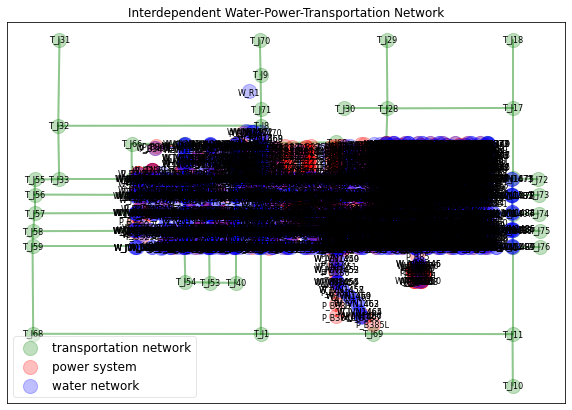

In [37]:
micropolis_network.generate_integrated_graph(plotting = True)

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [38]:
dependency_file = MAIN_DIR/f"dreaminsg_integrated_model/data/networks/{network_dir}/dependecies.csv"
micropolis_network.generate_dependency_table(dependency_file = dependency_file)
micropolis_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP1,P_LOMP1,Pump,Motor as Load
1,W_WP2,P_LOMP1,Pump,Motor as Load
2,W_WP3,P_LOMP1,Pump,Motor as Load
3,W_WP4,P_LOMP1,Pump,Motor as Load
4,W_WP5,P_LOMP2,Pump,Motor as Load
5,W_WP6,P_LOMP2,Pump,Motor as Load
6,W_WP7,P_LOMP2,Pump,Motor as Load
7,W_WP8,P_LOMP3,Pump,Motor as Load


In [39]:
micropolis_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B54,T_J22,power,Bus,171.75
1,P_B55,T_J22,power,Bus,388.26
2,P_B56,T_J63,power,Bus,164.74
3,P_B0,T_J65,power,Bus,84.79
4,P_B1,T_J65,power,Bus,16.96


### Set failed components

In [40]:
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/micropolis/micropolis_disruptions.csv"

micropolis_network.set_disrupted_components(scenario_file=scenario_file)
micropolis_network.get_disrupted_components()

['P_L172', 'P_LOA17']

In [41]:
micropolis_network.pipe_leak_node_generator()

### Set initial crew locations

In [42]:
micropolis_network.set_init_crew_locs(init_power_loc='T_J8',
init_water_loc='T_J8', init_transpo_loc='T_J8')

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [94]:
network_recovery = NetworkRecovery(micropolis_network, sim_step=60)

### (b) Create a simulation object

In [95]:
sim_step = (
    micropolis_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Generation of random repair order

In [96]:
#Generate a random repair order
repair_order = network_recovery.network.get_disrupted_components()
random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['P_L172', 'P_LOA17']


### (d) Generation of event tables

In [97]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

P_L172 ('power', 'L', 'line', 'Line')
P_LOA17 ('power', 'LOA', 'asymmetric_load', 'Asymmetric Load')


In [98]:
network_recovery.get_event_table()

,time_stamp,components,perf_level,component_state
0,0,P_L172,100,Functional
1,0,P_LOA17,100,Functional
2,6000,P_L172,25,Service Disrupted
3,6000,P_LOA17,25,Service Disrupted
4,7020,P_L172,25,Repairing
5,17700,P_L172,25,Repairing
6,17820,P_L172,100,Service Restored
7,17940,P_L172,100,Service Restored
8,18060,P_L172,100,Service Restored
9,18480,P_LOA17,25,Repairing


In [99]:
bf_simulation.expand_event_table(20)

In [100]:
network_recovery.get_event_table().head()

,time_stamp,components,perf_level,component_state
0,60,P_L172,100,Functional
1,60,P_LOA17,100,Functional
41,1560,P_LOA17,100,Functional
24,1560,P_L172,100,Functional
42,3060,P_LOA17,100,Functional


### (e) Simulation of interdependent effects

In [101]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

resilience_metrics.set_weighted_auc_metrics()


Simulating network conditions at 60 s
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60


C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Pump:  		status =  [1 1] 	flowrate =  [0.002 0.002]
Failed pipe:  		status =  [1 1] 	flowrate =  [-0.072 -0.072]
Tank:  		demand [0.036 0.036] 	head =  [352.044 352.056]
Pipe from Tank:  status [1 1] 	flowrate =  [-0.036 -0.036]
******************

Supply:  0.03606376159188452 Base demand:  0.0360637615782266

Simulating network conditions at 1560 s
Simulation time:  1560.0 ; Hydraulic time step:  60.0 ; Report time step:  1560
Pump:  		status =  [1] 	flowrate =  [0.002]
Failed pipe:  		status =  [1] 	flowrate =  [-0.072]
Tank:  		demand [0.036] 	head =  [352.349]
Pipe from Tank:  status [1] 	flowrate =  [-0.036]
******************

Supply:  0.03606376159198597 Base demand:  0.0360637615782266

Simulating network conditions at 3060 s
Simulation time:  3060.0 ; Hydraulic time step:  60.0 ; Report time step:  3060
Pump:  		status =  [1] 	flowrate =  [0.002]
Failed pipe:  		status =  [1] 	flowrate =  [-0.071]
Tank:  		demand [0.035] 	head =  [352.641]
Pipe from Tank:  status [1] 	flowrate

C:\Users\srijith\AppData\Roaming\Python\Python38\site-packages\pandapower\results_bus.py:54: RuntimeWarning: invalid value encountered in true_divide
  net["res_bus_3ph"]["unbalance_percent"] = np.abs(V012_pu[2, :]/V012_pu[1, :])*100
C:\Users\srijith\AppData\Roaming\Python\Python38\site-packages\pandapower\auxiliary.py:837: RuntimeWarning: invalid value encountered in true_divide
  return np.conjugate(np.divide(S, V, out=np.zeros_like(S), where=V != 0))  # Return zero if div by zero


Pump:  		status =  [1] 	flowrate =  [0.002]
Failed pipe:  		status =  [1] 	flowrate =  [-0.071]
Tank:  		demand [0.035] 	head =  [353.221]
Pipe from Tank:  status [1] 	flowrate =  [-0.035]
******************

Supply:  0.036063761592287344 Base demand:  0.0360637615782266

Simulating network conditions at 7080 s
Simulation time:  7080.0 ; Hydraulic time step:  60.0 ; Report time step:  7080
Pump:  		status =  [1] 	flowrate =  [0.002]
Failed pipe:  		status =  [1] 	flowrate =  [-0.071]
Tank:  		demand [0.035] 	head =  [353.416]
Pipe from Tank:  status [1] 	flowrate =  [-0.035]
******************

Supply:  0.03606376159235505 Base demand:  0.0360637615782266

Simulating network conditions at 7560 s
Simulation time:  7560.0 ; Hydraulic time step:  60.0 ; Report time step:  7560
Pump:  		status =  [1] 	flowrate =  [0.002]
Failed pipe:  		status =  [1] 	flowrate =  [-0.071]
Tank:  		demand [0.033] 	head =  [353.505]
Pipe from Tank:  status [1] 	flowrate =  [-0.033]
******************

Supply

### (f) Calculation of resilience metric

In [102]:
# auc = 0.5 * water_auc + 0.5 * power_auc
print(
    "Water AUC: ",
    round(resilience_metrics.water_auc, 3),
    "\t",
    "Power AUC: ",
    round(resilience_metrics.power_auc, 3),
    "\t",
    "Weighted AUC: ",
    round(resilience_metrics.weighed_auc, 3),
)

Water AUC:  0.998 	 Power AUC:  0.989 	 Weighted AUC:  0.994


### Plot the direct and interdependent effects

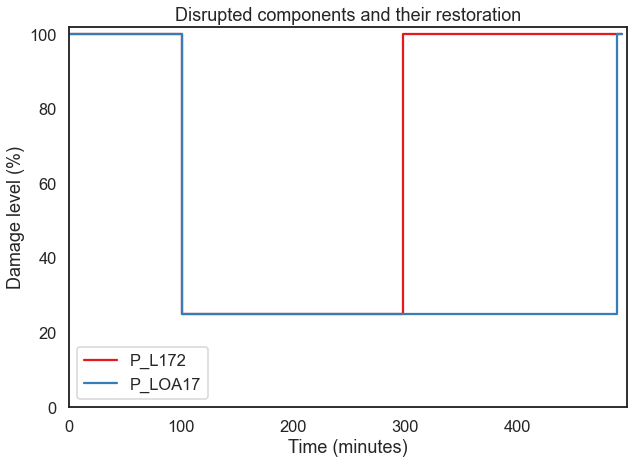

In [103]:
#Plotting repair curves
model_plots.plot_repair_curves(network_recovery, scatter = False)

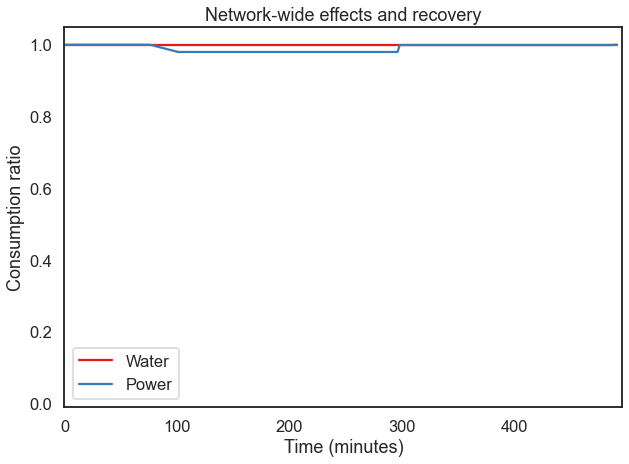

In [104]:
time_tracker, power_consump_tracker, water_consump_tracker = (
    resilience_metrics.time_tracker, 
    resilience_metrics.power_consump_tracker, 
    resilience_metrics.water_consump_tracker
    )

model_plots.plot_interdependent_effects(
        power_consump_tracker,
        water_consump_tracker,
        time_tracker,
        scatter=False,
    )

In [105]:
resilience_metrics.get_weighted_auc_metrics()

(0.9890787128484947, 0.997963340661192, 0.9935210267548433)

In [106]:
import dreaminsg_integrated_model.src.network_sim_models.interdependencies as interdependencies
import dreaminsg_integrated_model.src.network_sim_models.water.water_network_model as water
import dreaminsg_integrated_model.src.network_sim_models.power.power_system_model as power